In [1]:
# загружаем библиотеки
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
!pip install odfpy


In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


In [3]:
from sklearn.model_selection import train_test_split

from keras.models import Sequential 
from keras.layers import Dense

In [4]:
# загружаем датасет
df_bp = pd.read_excel('C:\datavkr/X_bp.xlsx')
df_nup = pd.read_excel('C:\datavkr/X_nup.xlsx')

In [5]:
data_bp = pd.read_excel('X_bp.xlsx', index_col=0)
data_nup = pd.read_excel('X_nup.xlsx', index_col=0)

In [6]:
df = data_bp.merge(data_nup, left_index=True, right_index=True, how='inner')

In [7]:
dfc = df.copy()

In [8]:
df.drop(['Плотность, кг/м3', 'модуль упругости, ГПа', 'Количество отвердителя, м.%', 'Содержание эпоксидных групп,%_2',
        'Температура вспышки, С_2', 'Поверхностная плотность, г/м2', 'Потребление смолы, г/м2', 'Угол нашивки, град',
         'Шаг нашивки','Плотность нашивки'], axis=1, inplace=True)

In [9]:
y = df['Соотношение матрица-наполнитель']
X = df.iloc[:, 1:]
X = X.astype(float)

In [10]:
X.shape

(1023, 2)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [12]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [13]:
normalizer.adapt(np.array(X))

In [14]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [15]:
SMN_model = build_and_compile_model(normalizer)
SMN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,582
Trainable params: 8,577
Non-trainable params: 5
______________________________________________________

In [16]:
%%time
history = SMN_model.fit(
    X_train,
    y_train,
    validation_split=0.3,
    verbose=1, epochs=100)

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 2.5615 - val_loss: 1.8989
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 1.4839 - val_loss: 1.0804
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 1.1378 - val_loss: 0.9980
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 1.0092 - val_loss: 0.9319
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.9354 - val_loss: 0.8594
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.8709 - val_loss: 0.7966
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.8065 - val_loss: 0.7412
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7650 - val_loss: 0.7252
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7407 - val_loss: 0.7056
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7315 - val_loss: 0.7130
Epoch 11

16/16 [==============================] - 0s 3ms/step - loss: 0.7375 - val_loss: 0.7089
Epoch 84/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7152 - val_loss: 0.7185
Epoch 85/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7171 - val_loss: 0.7156
Epoch 86/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7073 - val_loss: 0.7116
Epoch 87/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7134 - val_loss: 0.7143
Epoch 88/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7146 - val_loss: 0.7058
Epoch 89/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7138 - val_loss: 0.7182
Epoch 90/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7107 - val_loss: 0.7148
Epoch 91/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7114 - val_loss: 0.7159
Epoch 92/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7216 - val_loss: 0.7165
Epoch 93/100


In [17]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 4])
    plt.xlabel('Эпоха')
    plt.ylabel('MAE [SMN]')
    plt.legend()
    plt.grid(True)

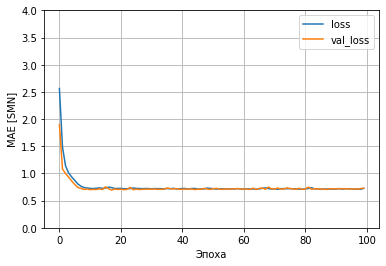

In [18]:
plot_loss(history)

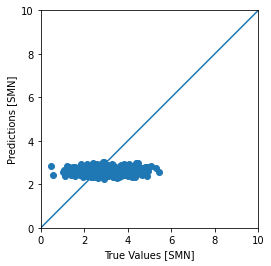

In [19]:
test_predictions = SMN_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [SMN]')
plt.ylabel('Predictions [SMN]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [21]:
test_predictions

array([2.4354343, 2.7426124, 2.6945324, 2.9001732, 2.617447 , 2.9252386,
       2.6276276, 2.923011 , 2.6419382, 2.6732726, 2.726435 , 2.5589623,
       2.8489728, 2.77708  , 2.714499 , 2.7738552, 2.952556 , 2.5716853,
       2.374701 , 2.622468 , 2.9542708, 2.644262 , 2.8170705, 2.6609716,
       2.6214542, 2.6282067, 2.6633823, 2.830584 , 2.7749562, 2.4298801,
       2.6390882, 2.79379  , 2.5743046, 2.3836927, 2.580157 , 2.6752808,
       2.6230597, 2.3567352, 2.5044544, 2.4430122, 2.758699 , 2.5757723,
       2.7776833, 2.6964045, 2.769217 , 2.6798358, 3.0232077, 2.5244331,
       2.4813266, 2.4485645, 2.7974806, 2.761332 , 2.6702032, 2.9693975,
       2.619112 , 2.57576  , 2.504383 , 2.8547406, 2.6502202, 2.679267 ,
       2.7919436, 2.8390045, 2.9003286, 2.7292354, 2.549241 , 2.228512 ,
       2.6945462, 2.5250678, 2.7710032, 2.581418 , 2.8469753, 2.5479763,
       2.6712751, 2.810388 , 2.5976615, 2.7248793, 2.675469 , 2.7838   ,
       2.6349947, 2.3370147, 2.722533 , 2.765195 , 

In [23]:
np.array(y_test)

array([1.39746741, 4.65302304, 1.30471524, 3.70684185, 1.71278339,
       1.84692315, 2.22591379, 2.74842593, 3.9645425 , 2.55872832,
       2.3228007 , 2.68378418, 2.12793532, 1.84781686, 3.47604419,
       2.69165914, 2.14361668, 2.00714056, 3.53233831, 2.7913665 ,
       3.26024967, 1.77143639, 3.18897084, 2.3346238 , 2.16356687,
       1.85714286, 4.69954982, 3.31124395, 2.75099835, 3.15028096,
       3.04339274, 4.77007291, 2.54747769, 3.67613708, 2.10688771,
       3.04851307, 2.66433264, 2.40862614, 4.23515011, 2.67845916,
       2.53232273, 2.04135216, 1.48741882, 4.23447302, 3.85619939,
       4.43442906, 2.91988882, 2.86456811, 3.60467385, 2.69435568,
       2.39264274, 1.49775914, 2.82057107, 4.36354803, 2.46520497,
       3.55003786, 3.36714703, 2.77339993, 2.13255232, 1.94002141,
       4.13173714, 2.88723834, 3.33185976, 1.81639249, 3.59014039,
       2.90330482, 3.27283978, 4.27532534, 3.95035176, 5.42513947,
       1.19759562, 2.96726775, 3.44402233, 3.13492164, 3.13484

In [24]:
np.array(X_test)

array([[  80.69149876, 2404.06892149],
       [  70.61151255, 2610.44976693],
       [  71.8603625 , 2823.01218855],
       [  68.36796611, 2192.55901809],
       [  71.01025033, 1891.00820444],
       [  64.6964004 , 2436.27365928],
       [  72.70767761, 1982.87824219],
       [  69.40597515, 2348.28626605],
       [  69.47749394, 2986.64164432],
       [  74.20579536, 2921.97971413],
       [  72.04695237, 2342.25420208],
       [  77.04389795, 3520.74185734],
       [  68.97646599, 2511.37362444],
       [  73.34746511, 2739.92955343],
       [  72.29826892, 2741.6733319 ],
       [  73.06781387, 2752.011938  ],
       [  67.02650823, 2133.59114679],
       [  76.05777513, 2573.98026748],
       [  78.        , 2000.        ],
       [  72.29137456, 1739.13829603],
       [  67.80367996, 2421.36969798],
       [  70.94759156, 2796.78540176],
       [  72.56299934, 2597.67771013],
       [  71.70266838, 2122.10165507],
       [  72.63869544, 1901.32314371],
       [  70.        , 30

In [25]:
np.array(X_test)[0]

array([  80.69149876, 2404.06892149])

In [26]:
X_test.head(1)

Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа
735                             80.691499                    2404.068921

In [27]:
SMN = np.array(X_test)[0]

In [28]:
SMN.shape

(2,)

In [29]:
SMN.reshape((1, 2))

array([[  80.69149876, 2404.06892149]])

In [32]:
SMN_model.predict(SMN.reshape((1, 2)))[0][0]

2.435434

In [33]:
SMN_model.predict([[67., 2970]])[0][0]

2.5697248